# Introduction

The Algorithm** Fuzzy c-means (FCM) is a method of clustering which allows one piece of data to belong to two or more clusters. This method (developed by Dunn in 1973 and improved by Bezdek in 1981) is frequently used in pattern recognition.

#### Loading modules and training data

In [2]:
import pandas as pd # reading all required header files
import numpy as np
import random
import operator
import math
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal     # for generating pdf

#### Loading Dataset

In [8]:
df_full = pd.read_csv("Iris.csv") #iris data
df_full = df_full.drop(['Id'], axis=1)
df_full.shape

(150, 5)

In [9]:
df_full.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### We extract features from dataset (Knowledge extraction)

In [10]:
columns = list(df_full.columns)
features = columns[:len(columns)-1]
class_labels = list(df_full[columns[-1]])
df = df_full[features]

In [11]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Defining parameters
Here I have only created 3 clusters because we have 3 classes in the Iris data. The MAX_ITER parameter acts as a fuse in our loop inorder to prevent us from the infinite loop. Next, is the fuzzy parameter, if the value is 1 its same as K-nearest neighbours I have taken the value as 1.7

In [12]:
# Number of Clusters
k = 3
# Maximum number of iterations
MAX_ITER = 100
# Number of data points
n = len(df)
# Fuzzy parameter
m = 1.7 #Select a value greater than 1 else it will be knn

## Ploting dataset

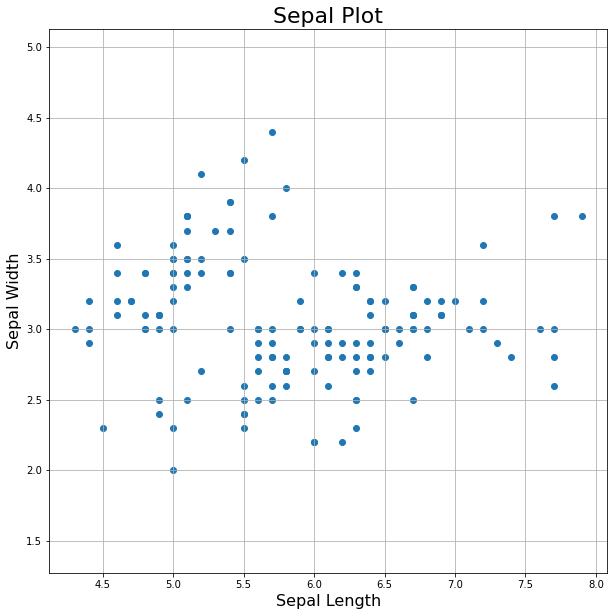

In [13]:
plt.figure(figsize=(10,10))                #scatter plot of sepal length vs sepal width                              
plt.scatter(list(df.iloc[:,0]), list(df.iloc[:,1]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                 
plt.title('Sepal Plot', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

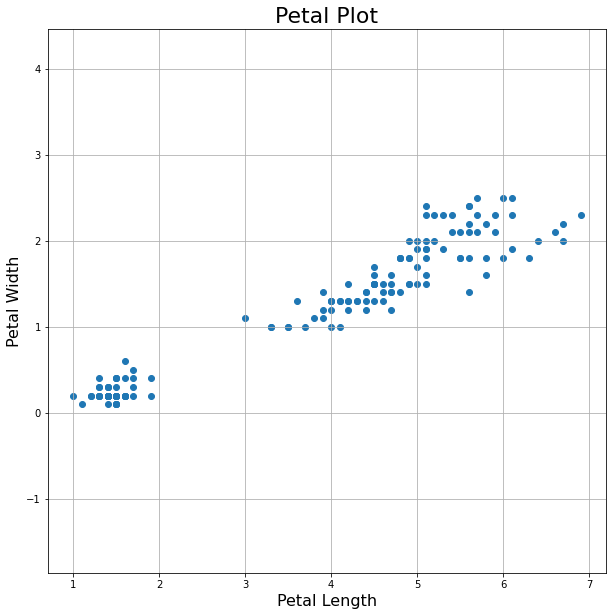

In [14]:
plt.figure(figsize=(10,10))                    #scatter plot of petal length vs sepal width                          
plt.scatter(list(df.iloc[:,2]), list(df.iloc[:,3]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Petal Length', fontsize=16)                                                 
plt.ylabel('Petal Width', fontsize=16)                                                 
plt.title('Petal Plot', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

In [15]:
#Calculating the accuracy
# P.S. The accuracy calculation is for iris data only
def accuracy(cluster_labels, class_labels):
    correct_pred = 0
    #print(cluster_labels)
    seto = max(set(labels[0:50]), key=labels[0:50].count)
    vers = max(set(labels[50:100]), key=labels[50:100].count)
    virg = max(set(labels[100:]), key=labels[100:].count)
    
    for i in range(len(df)):
        if cluster_labels[i] == seto and class_labels[i] == 'Iris-setosa':
            correct_pred = correct_pred + 1
        if cluster_labels[i] == vers and class_labels[i] == 'Iris-versicolor' and vers!=seto:
            correct_pred = correct_pred + 1
        if cluster_labels[i] == virg and class_labels[i] == 'Iris-virginica' and virg!=seto and virg!=vers:
            correct_pred = correct_pred + 1
            
    accuracy = (correct_pred/len(df))*100
    return accuracy

## Initializing membership function randomly

In [16]:
def initializeMembershipMatrix(): # initializing the membership matrix
    membership_mat = []
    for i in range(n):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        
        flag = temp_list.index(max(temp_list))
        for j in range(0,len(temp_list)):
            if(j == flag):
                temp_list[j] = 1
            else:
                temp_list[j] = 0
        
        membership_mat.append(temp_list)
    return membership_mat

In [17]:
membership_mat = initializeMembershipMatrix()

## Calculating Cluster Center

In [18]:
def calculateClusterCenter(membership_mat): # calculating the cluster center
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = []
    for j in range(k):
        x = list(cluster_mem_val[j])
        xraised = [p ** m for p in x]
        denominator = sum(xraised)
        temp_num = []
        for i in range(n):
            data_point = list(df.iloc[i])
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, list(zip(*temp_num)))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

In [19]:
#cluster_centers = calculateClusterCenter(membership_mat)
calculateClusterCenter(membership_mat)

[[5.86888888888889, 3.0244444444444443, 3.962222222222221, 1.2711111111111109],
 [5.898387096774193,
  3.1225806451612907,
  3.7387096774193544,
  1.2161290322580642],
 [5.73720930232558, 2.986046511627907, 3.5744186046511617, 1.097674418604651]]

## Updating Membership Value

In [20]:
def updateMembershipValue(membership_mat, cluster_centers): # Updating the membership value
    p = float(2/(m-1))
    for i in range(n):
        x = list(df.iloc[i])
        distances = [np.linalg.norm(np.array(list(map(operator.sub, x, cluster_centers[j])))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)       
    return membership_mat

## Getting the clusters

In [21]:
def getClusters(membership_mat): # getting the clusters
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

Below are three different initializations. When the initialization is at the origin all points converge into one cluster and for the other 2 cases we get the clusters as we have initialized before(3 in this code)**


## Fuzzy C-Means with cluster centres at the origin

In [22]:
def fuzzyCMeansClustering(): #First Iteration with centers at 0
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    cent_temp = [[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]]
    while curr < MAX_ITER:
        if(curr == 0):
            cluster_centers = cent_temp
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        else:
            cluster_centers = calculateClusterCenter(membership_mat)
        #cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        acc.append(cluster_labels)
        curr += 1
    print("---------------------------")
    print("Membership Matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

## Fuzzy C-Means with with cluster centers at random locations within a multi-variate Gaussian distribution with zero-mean and unit-variance.

In [23]:
def fuzzyCMeansClustering(): #Second Iteration Multivariate Gaussian
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    
    lis1,cent_temp=[],[]
    
    for i in range(0,k):
        Z = list(np.random.multivariate_normal(mean, cov))
        Z1 = list(np.random.multivariate_normal(mean, cov))
        lis1 = Z+Z1
        cent_temp.append(lis1)
    
    
    while curr < MAX_ITER:
        if(curr == 0):
            cluster_centers = cent_temp
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        else:
            cluster_centers = calculateClusterCenter(membership_mat)
        #cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        acc.append(cluster_labels)
        curr += 1
    print("---------------------------")
    print("Membership Matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

## Fuzzy C-Means with cluster centers at random vectors chosen from the data.

In [24]:
def fuzzyCMeansClustering(): #Third iteration Random vectors from data
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    while curr < MAX_ITER:
        cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        
        acc.append(cluster_labels)
        
        if(curr == 0):
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        curr += 1
    print("---------------------------")
    print("Partition matrix:")
    print(np.array(membership_mat))
    #return cluster_labels, cluster_centers
    return cluster_labels, cluster_centers, acc

## Calculating accuracy

In [25]:
labels, centers, acc = fuzzyCMeansClustering()
a = accuracy(labels, class_labels)

Cluster Centers:
[[5.82692308 3.03653846 3.73269231 1.22692308]
 [5.96808511 3.05531915 3.94893617 1.25744681]
 [5.74509804 3.07058824 3.60980392 1.11568627]]
---------------------------
Partition matrix:
[[1.72424329e-04 5.67819162e-05 9.99770794e-01]
 [2.82446451e-03 8.86481003e-04 9.96289054e-01]
 [2.17929773e-03 7.19013163e-04 9.97101689e-01]
 [4.49283135e-03 1.40779918e-03 9.94099369e-01]
 [3.63741759e-04 1.21557690e-04 9.99514701e-01]
 [1.29758903e-02 4.21005758e-03 9.82814052e-01]
 [2.30718744e-03 7.57109076e-04 9.96935703e-01]
 [8.40484306e-06 2.66508464e-06 9.99988930e-01]
 [1.38351228e-02 4.45892768e-03 9.81705950e-01]
 [1.72962558e-03 5.38252020e-04 9.97732122e-01]
 [4.41894904e-03 1.47299186e-03 9.94108059e-01]
 [5.91849425e-04 1.84218020e-04 9.99223933e-01]
 [3.77067942e-03 1.20017378e-03 9.95029147e-01]
 [1.57289028e-02 5.52748695e-03 9.78743610e-01]
 [2.67674268e-02 1.03172071e-02 9.62915366e-01]
 [4.74741073e-02 1.84083981e-02 9.34117495e-01]
 [9.16970181e-03 3.27260430

In [26]:
acc_lis = [] 
for i in range(0,len(acc)):
    val = accuracy(acc[i], class_labels)
    acc_lis.append(val)

In [27]:
acc_lis = np.array(acc_lis) #calculating accuracy and std deviation 100 times
print("mean=",np.mean(acc_lis))
print("Std dev=",np.std(acc_lis))

mean= 88.43999999999997
Std dev= 2.3442032524695655


In [28]:
print("Accuracy = " + str(round(a, 2)))

Accuracy = 88.67


## Ploting data

In [34]:
sepal_df = df_full.iloc[:,0:2]
sepal_df = np.array(sepal_df)

In [35]:
#First initialization
#m1 = [0,0]
#m2 = [0,0]
#m3 = [0,0]
#Second initialization
#m1 = [-0.47534495, -0.16392118]
#m2 = [0.89019389, -1.19440781]
#m3 = [1.29107135, 0.48248487]
#Third initialization
m1 = random.choice(sepal_df)
m2 = random.choice(sepal_df)
m3 = random.choice(sepal_df)

cov1 = np.cov(np.transpose(sepal_df))
cov2 = np.cov(np.transpose(sepal_df))
cov3 = np.cov(np.transpose(sepal_df))

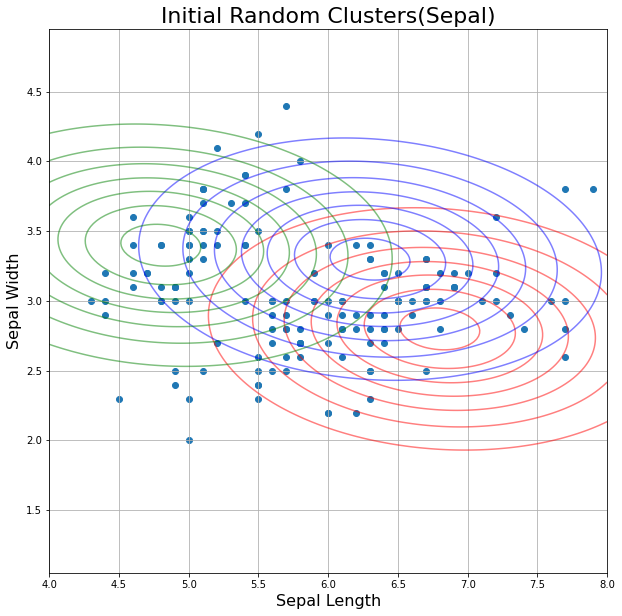

In [36]:
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
#x1 = np.linspace(-1,8,150)  
#x2 = np.linspace(-1,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)
Z3 = multivariate_normal(m3, cov3)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(sepal_df[:,0], sepal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Sepal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Sepal Width', fontsize=16)                                                  # Y-Axis
plt.title('Initial Random Clusters(Sepal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [37]:
petal_df = df_full.iloc[:,2:4]
petal_df = np.array(petal_df)

In [38]:
#first initialization
#m1 = [0,0]
#m2 = [0,0]
#m3 = [0,0]
#second initialization
#m1 = [-0.8005044 , -0.7017542]
#m2 = [-2.17962154, -0.96475807]
#m3 = [-0.68988961,  0.54596565]
#third initialization
m1 = random.choice(petal_df)
m2 = random.choice(petal_df)
m3 = random.choice(petal_df)
cov1 = np.cov(np.transpose(petal_df))
cov2 = np.cov(np.transpose(petal_df))
cov3 = np.cov(np.transpose(petal_df))

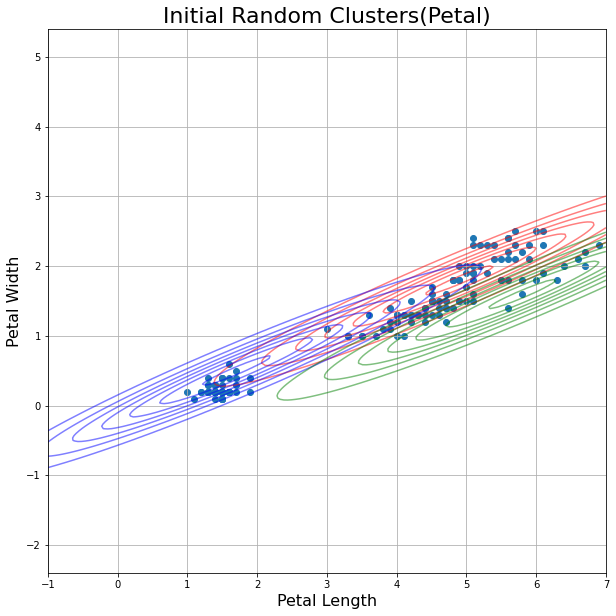

In [39]:
#x1 = np.linspace(0.5,7,150)  
#x2 = np.linspace(-1,4,150)
x1 = np.linspace(-1,7,150)
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)
Z3 = multivariate_normal(m3, cov3)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Petal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Petal Width', fontsize=16)                                                  # Y-Axis
plt.title('Initial Random Clusters(Petal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [45]:
#finding mode
seto = max(set(labels[0:50]), key=labels[0:50].count)
vers = max(set(labels[50:100]), key=labels[50:100].count)
virg = max(set(labels[100:]), key=labels[100:].count)
#sepal
s_mean_clus1 = np.array([centers[seto][0],centers[seto][1]])
s_mean_clus2 = np.array([centers[vers][0],centers[vers][1]])
s_mean_clus3 = np.array([centers[virg][0],centers[virg][1]])
values = np.array(labels) #label

#search all 3 species
searchval_seto = seto
searchval_vers = vers
searchval_virg = virg

#index of all 3 species
ii_seto = np.where(values == searchval_seto)[0]
ii_vers = np.where(values == searchval_vers)[0]
ii_virg = np.where(values == searchval_virg)[0]
ind_seto = list(ii_seto)
ind_vers = list(ii_vers)
ind_virg = list(ii_virg)
sepal_df = df_full.iloc[:,0:2]
seto_df = sepal_df[sepal_df.index.isin(ind_seto)]
vers_df = sepal_df[sepal_df.index.isin(ind_vers)]
virg_df = sepal_df[sepal_df.index.isin(ind_virg)]
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))
sepal_df = np.array(sepal_df)


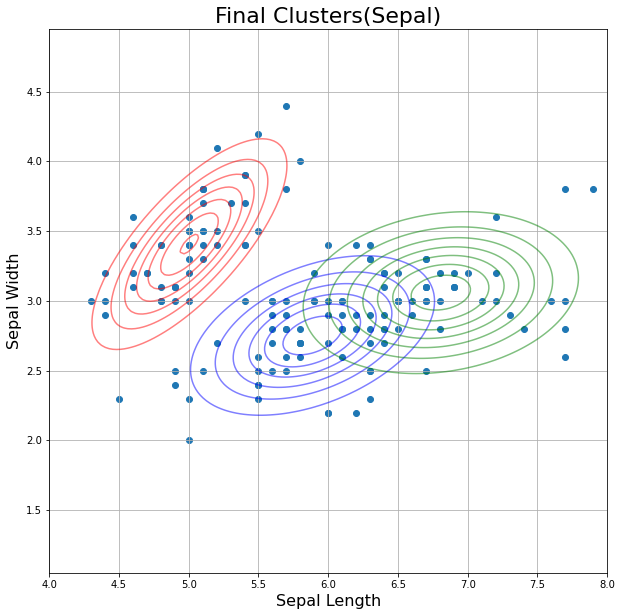

In [46]:
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(s_mean_clus1, cov_seto)  
Z2 = multivariate_normal(s_mean_clus2, cov_vers)
Z3 = multivariate_normal(s_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(sepal_df[:,0], sepal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Sepal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Sepal Width', fontsize=16)                                                  # Y-Axis
plt.title('Final Clusters(Sepal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [47]:
#petal
p_mean_clus1 = np.array([centers[seto][2],centers[seto][3]])
p_mean_clus2 = np.array([centers[vers][2],centers[vers][3]])
p_mean_clus3 = np.array([centers[virg][2],centers[virg][3]])
petal_df = df_full.iloc[:,2:4]
seto_df = petal_df[petal_df.index.isin(ind_seto)]
vers_df = petal_df[petal_df.index.isin(ind_vers)]
virg_df = petal_df[petal_df.index.isin(ind_virg)]
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))
petal_df = np.array(petal_df)

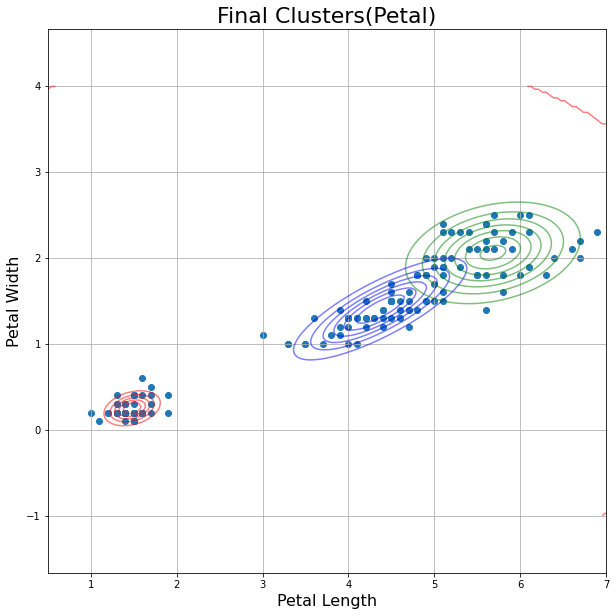

In [48]:
x1 = np.linspace(0.5,7,150)  
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(p_mean_clus1, cov_seto)  
Z2 = multivariate_normal(p_mean_clus2, cov_vers)
Z3 = multivariate_normal(p_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Petal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Petal Width', fontsize=16)                                                  # Y-Axis
plt.title('Final Clusters(Petal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()